**Chapter 2.**
**MapReduce with Python**

MapReduce is a programming model that enables large volumes of data to be processed and generated by dividing work into independent tasks and executing the tasks in parallel across a cluster of machines. The MapReduce programming style was inspired by the functional programming constructs map and reduce, which are commonly used to process lists of data. At a high level, every MapReduce program transforms a list of input data elements into a list of output data elements twice, once in the map phase and once in the reduce phase.

This chapter begins by introducing the MapReduce programming model and describing how data flows through the different phases of the model. Examples then show how MapReduce jobs can be written in Python.

**Data Flow**

The MapReduce framework is composed of three major phases: map, shuffle and sort, and reduce. This section describes each phase in detail.

**Map**

The first phase of a MapReduce application is the map phase. Within the map phase, a function (called the mapper) processes a series of key-value pairs. The mapper sequentially processes each key-value pair individually, producing zero or more output key-value pairs **(Figure 2-1)**.

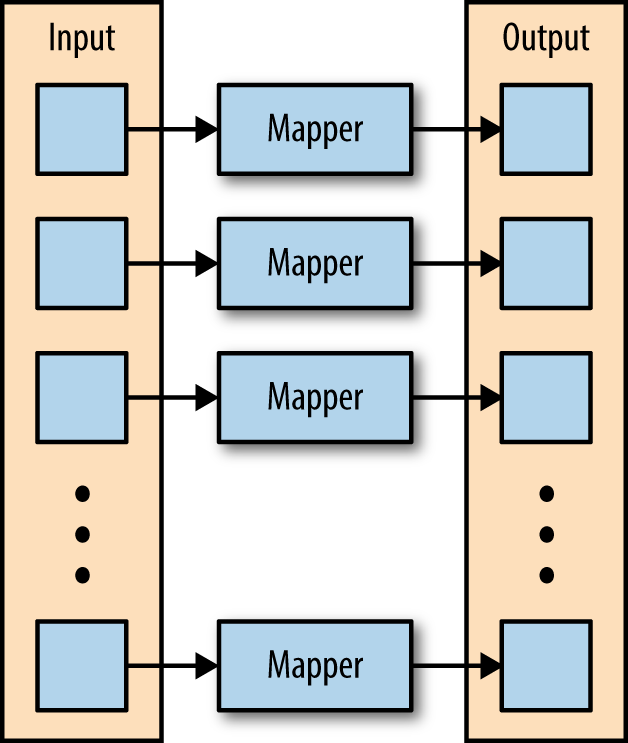

The mapper is applied to each input key-value pair, producing an output key-value pair

As an example, consider a mapper whose purpose is to transform sentences into words. The input to this mapper would be strings that contain sentences, and the mapper’s function would be to split the sentences into words and output the words **(Figure 2-2)**.

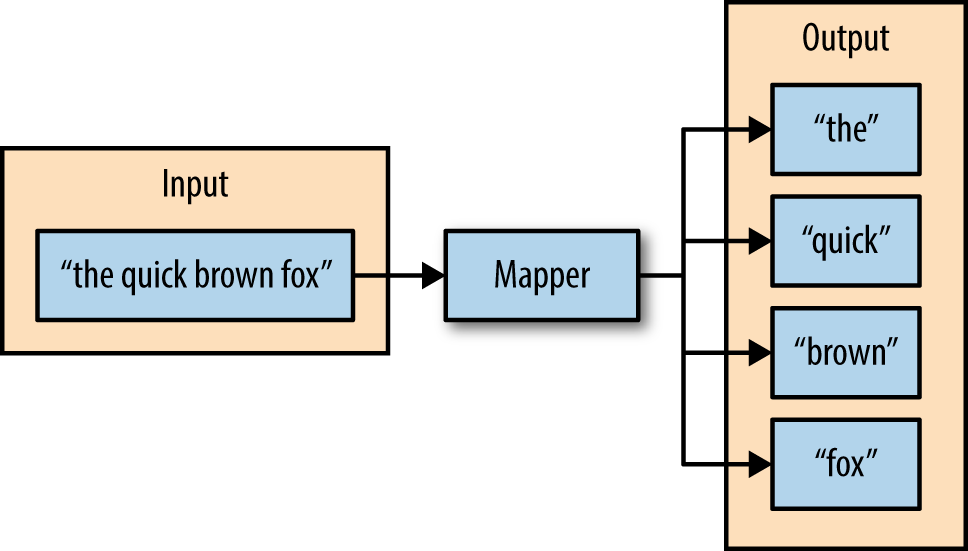

The input of the mapper is a string, and the function of the mapper is to split the input on spaces; the resulting output is the individual words from the mapper’s input.

**Shuffle and Sort**

The second phase of MapReduce is the shuffle and sort. As the mappers begin completing, the intermediate outputs from the map phase are moved to the reducers. This process of moving output from the mappers to the reducers is known as shuffling.

Shuffling is handled by a partition function, known as the partitioner. The partitioner is used to control the flow of key-value pairs from mappers to reducers. The partitioner is given the mapper’s output key and the number of reducers, and returns the index of the intended reducer. The partitioner ensures that all of the values for the same key are sent to the same reducer. The default partitioner is hash-based. It computes a hash value of the mapper’s output key and assigns a partition based on this result.

The final stage before the reducers start processing data is the sorting process. The intermediate keys and values for each partition are sorted by the Hadoop framework before being presented to the reducer.

**Reduce**

The third phase of MapReduce is the reduce phase. Within the reducer phase, an iterator of values is provided to a function known as the reducer. The iterator of values is a nonunique set of values for each unique key from the output of the map phase. The reducer aggregates the values for each unique key and produces zero or more output key-value pairs **(Figure 2-3)**.

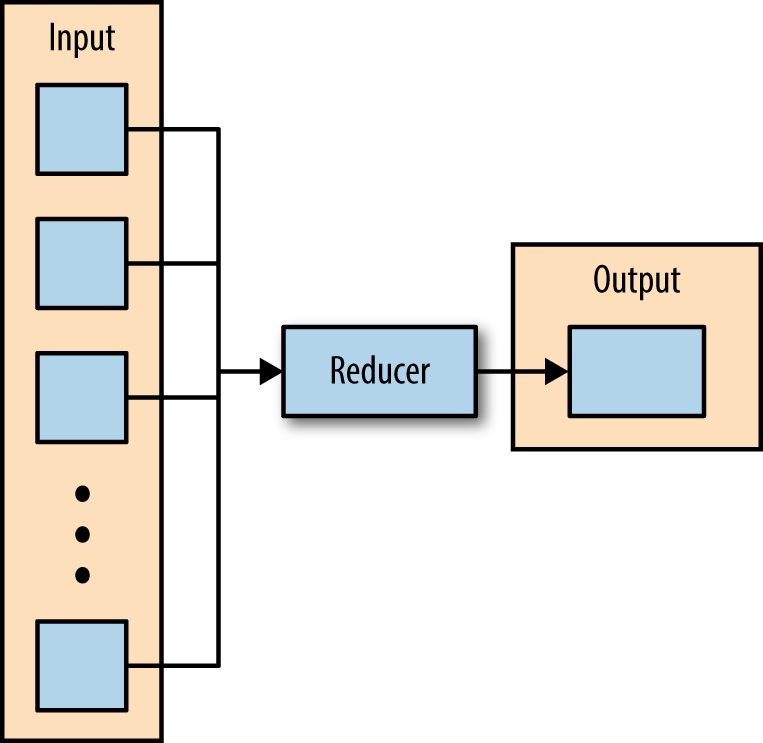

The reducer iterates over the input values, producing an output key-value pair

As an example, consider a reducer whose purpose is to sum all of the values for a key. The input to this reducer is an iterator of all of the values for a key, and the reducer sums all of the values. The reducer then outputs a key-value pair that contains the input key and the sum of the input key values **(Figure 2-4)**.

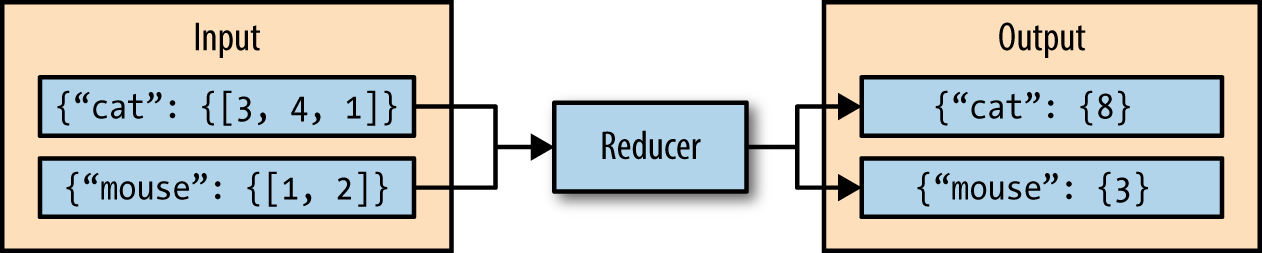
This reducer sums the values for the keys “cat” and “mouse”

**Hadoop Streaming**

Hadoop streaming is a utility that comes packaged with the Hadoop distribution and allows MapReduce jobs to be created with any executable as the mapper and/or the reducer. The Hadoop streaming utility enables Python, shell scripts, or any other language to be used as a mapper, reducer, or both.

**How It Works**

The mapper and reducer are both executables that read input, line by line, from the standard input (stdin), and write output to the standard output (stdout). The Hadoop streaming utility creates a MapReduce job, submits the job to the cluster, and monitors its progress until it is complete.

When the mapper is initialized, each map task launches the specified executable as a separate process. The mapper reads the input file and presents each line to the executable via stdin. After the executable processes each line of input, the mapper collects the output from stdout and converts each line to a key-value pair. The key consists of the part of the line before the first tab character, and the value consists of the part of the line after the first tab character. If a line contains no tab character, the entire line is considered the key and the value is null.

When the reducer is initialized, each reduce task launches the specified executable as a separate process. The reducer converts the input key-value pair to lines that are presented to the executable via stdin. The reducer collects the executables result from stdout and converts each line to a key-value pair. Similar to the mapper, the executable specifies key-value pairs by separating the key and value by a tab character.

**A Python Example**

To demonstrate how the Hadoop streaming utility can run Python as a MapReduce application on a Hadoop cluster, the WordCount application can be implemented as two Python programs: `mapper.py` and `reducer.py`.

`mapper.py` is the Python program that implements the logic in the map phase of WordCount. It reads data from stdin, splits the lines into words, and outputs each word with its intermediate count to stdout. The code in Example 2-1 implements the logic in `mapper.py`.

**Example 2-1. python/MapReduce/HadoopStreaming/mapper.py**

In [ ]:
#!/usr/bin/env python

import sys

# Read each line from stdin
for line in sys.stdin:

  # Get the words in each line
  words = line.split()

  # Generate the count for each word
  for word in words:

     # Write the key-value pair to stdout to be processed by 
     # the reducer.
     # The key is anything before the first tab character and the 
     #value is anything after the first tab character.
     print '{0}\t{1}'.format(word, 1)

`reducer.py` is the Python program that implements the logic in the reduce phase of WordCount. It reads the results of `mapper.py` from stdin, sums the occurrences of each word, and writes the result to stdout. The code in Example 2-2 implements the logic in `reducer.py`.

**Example 2-2. python/MapReduce/HadoopStreaming/reducer.py**

In [ ]:
#!/usr/bin/env python

import sys

curr_word = None
curr_count = 0

# Process each key-value pair from the mapper
for line in sys.stdin:

  # Get the key and value from the current line
  word, count = line.split('\t')

  # Convert the count to an int
  count = int(count)

  # If the current word is the same as the previous word, 
  # increment its count, otherwise print the words count 
  # to stdout
  if word == curr_word:
     curr_count += count
  else:

     # Write word and its number of occurrences as a key-value 
     # pair to stdout
     if curr_word:
        print '{0}\t{1}'.format(curr_word, curr_count)

     curr_word = word
     curr_count = count

# Output the count for the last word
if curr_word == word:
  print '{0}\t{1}'.format(curr_word, curr_count)

Before attempting to execute the code, ensure that the `mapper.py` and `reducer.py` files have execution permission. The following command will enable this for both files:

In [ ]:
$ chmod a+x mapper.py reducer.py

Also ensure that the first line of each file contains the proper path to Python. This line enables mapper.py and reducer.py to execute as standalone executables. The value `#!/usr/bin/env python` should work for most systems, but if it does not, replace `/usr/bin/env python` with the path to the Python executable on your system.

To test the Python programs locally before running them as a MapReduce job, they can be run from within the shell using the `echo` and `sort` commands. It is highly recommended to test all programs locally before running them across a Hadoop cluster.

In [ ]:
$ echo 'jack be nimble jack be quick' | ./mapper.py 
| sort -t 1 | ./reducer.py
be      2
jack    2
nimble  1
quick   1

Once the mapper and reducer programs are executing successfully against tests, they can be run as a MapReduce application using the Hadoop streaming utility. The command to run the Python programs `mapper.py` and `reducer.py` on a Hadoop cluster is as follows:

In [ ]:
$ $HADOOP_HOME/bin/hadoop jar 
  $HADOOP_HOME/mapred/contrib/streaming/hadoop-streaming*.jar \
-files mapper.py,reducer.py \
-mapper mapper.py \
-reducer reducer.py \
-input /user/hduser/input.txt -output /user/hduser/output

The options used with the Hadoop streaming utility are listed in Table 2-1.

**Table 2-1. Options for Hadoop streaming**

Option	        Description
-files	        A command-separated list of files to be copied to the MapReduce cluster
-mapper	        The command to be run as the mapper
-reducer	    The command to be run as the reducer
-input	        The DFS input path for the Map step
-output	        The DFS output directory for the Reduce step

**mrjob**

mrjob is a Python MapReduce library, created by Yelp, that wraps Hadoop streaming, allowing MapReduce applications to be written in a more Pythonic manner. mrjob enables multistep MapReduce jobs to be written in pure Python. MapReduce jobs written with mrjob can be tested locally, run on a Hadoop cluster, or run in the cloud using Amazon Elastic MapReduce (EMR).

Writing MapReduce applications with mrjob has many benefits:

    - mrjob is currently a very actively developed framework with multiple commits every week.
    - mrjob has extensive documentation, more than any other framework or library that supports Python on Hadoop.
    - mrjob applications can be executed and tested without having Hadoop installed, enabling development and testing before deploying to a Hadoop cluster.
    - mrjob allows MapReduce applications to be written in a single class, instead of writing separate programs for the mapper and reducer.

While mrjob is a great solution, it does have its drawbacks. mrjob is simplified, so it doesn’t give the same level of access to Hadoop that other APIs offer. mrjob does not use typedbytes, so other libraries may be faster.

**Installation**
The installation of mrjob is simple; it can be installed with `pip` by using the following command:

In [ ]:
$ pip install mrjob

Or it can be installed from source (a git clone):

In [ ]:
$ python setup.py install

**WordCount in mrjob**

Example 2-3 uses mrjob to implement the WordCount algorithm.

**Example 2-3. python/MapReduce/mrjob/word_count.py**

In [ ]:
from mrjob.job import MRJob

class MRWordCount(MRJob):

   def mapper(self, _, line):
      for word in line.split():
         yield(word, 1)

   def reducer(self, word, counts):
      yield(word, sum(counts))

if __name__ == '__main__':
   MRWordCount.run()

To run the mrjob locally, the only thing needed is a body of text. To run the job locally and count the frequency of words within a file named `input.txt`, use the following command:

In [ ]:
$ python word_count.py input.txt

The output depends on the contents of the input file, but should look similar to Example 2-4.

**Example 2-4. Output from word_count.py**

In [ ]:

"be"    2
"jack"    2
"nimble"    1
"quick"    1

**What Is Happening**

The MapReduce job is defined as the class, MRWordCount. Within the mrjob library, the class that inherits from MRJob contains the methods that define the steps of the MapReduce job. The steps within an mrjob application are mapper, combiner, and reducer. The class inheriting MRJob only needs to define one of these steps.

The `mapper()` method defines the mapper for the MapReduce job. It takes key and value as arguments and yields tuples of (output_key, output_value). In the WordCount example (Example 2-4), the mapper ignored the input key and split the input value to produce words and counts.

The `combiner()` method defines the combiner for the MapReduce job. The combiner is a process that runs after the mapper and before the reducer. It receives, as input, all of the data emitted by the mapper, and the output of the combiner is sent to the reducer. The combiner’s input is a key, which was yielded by the mapper, and a value, which is a generator that yields all values yielded by one mapper that corresponds to the key. The combiner yields tuples of (output_key, output_value) as output.

The `reducer()` method defines the reducer for the MapReduce job. It takes a key and an iterator of values as arguments and yields tuples of (output_key, output_value). In Example 2-4, the reducer sums the value for each key, which represents the frequency of words in the input.

The final component of a MapReduce job written with the mrjob library is the two lines at the end of the file:

In [ ]:
if __name__ == '__main__':
   MRWordCount.run()

These lines enable the execution of mrjob; without them, the application will not work.

**Executing mrjob**

Executing a MapReduce application with mrjob is similar to executing any other Python program. The command line must contain the name of the mrjob application and the input file:

In [ ]:
$ python mr_job.py input.txt

By default, mrjob writes output to stdout.

Multiple files can be passed to mrjob as inputs by specifying the filenames on the command line:

In [ ]:
$ python mr_job.py input1.txt input2.txt input3.txt

mrjob can also handle input via stdin:

By default, mrjob runs locally, allowing code to be developed and debugged before being submitted to a Hadoop cluster.

To change how the job is run, specify the `-r/--runner` option. **Table 2-2** contains a description of the valid choices for the runner options.

**Table 2-2. mrjob runner choices**

`-r inline`	    (Default) Run in a single Python process
`-r local`	    Run locally in a few subprocesses simulating some Hadoop features
`-r hadoop`	    Run on a Hadoop cluster
`-r emr`	    Run on Amazon Elastic Map Reduce (EMR)

Using the runner option allows the mrjob program to be run on a Hadoop cluster, with input being specified from HDFS:

In [ ]:
$ python mr_job.py -r hadoop hdfs://input/input.txt

mrjob also allows applications to be run on EMR directly from the command line:

In [ ]:
$ python mr_job.py -r emr s3://input-bucket/input.txt

**Top Salaries**

Example 2-5 uses mrjob to compute employee top annual salaries and gross pay. The dataset used is the salary information from the city of Baltimore for 2014.

**Example 2-5. python/MapReduce/mrjob/top_salary.py**

In [ ]:
from mrjob.job import MRJob
from mrjob.step import MRStep
import csv

cols = 'Name,JobTitle,AgencyID,Agency,HireDate,AnnualSalary,GrossPay'.split(',')

class salarymax(MRJob):

    def mapper(self, _, line):
        # Convert each line into a dictionary
        row = dict(zip(cols, [ a.strip() for a in csv.reader([line]).next()]))

        # Yield the salary
        yield 'salary', (float(row['AnnualSalary'][1:]), line)
        
        # Yield the gross pay
        try:
            yield 'gross', (float(row['GrossPay'][1:]), line)
        except ValueError:
            self.increment_counter('warn', 'missing gross', 1)

    def reducer(self, key, values):
        topten = []

        # For 'salary' and 'gross' compute the top 10
        for p in values:
            topten.append(p)
            topten.sort()
            topten = topten[-10:]

        for p in topten:
            yield key, p

    combiner = reducer

if __name__ == '__main__':
    salarymax.run()

Use the following command to execute the MapReduce job on Hadoop:

In [ ]:
$ python top_salary.py -r hadoop hdfs:///user/hduser/input/salaries.csv

**Chapter Summary**

This chapter introduced the MapReduce programming model and described how data flows through the different phases of the model. Hadoop Streaming and mrjob were then used to highlight how MapReduce jobs can be written in Python.